In [2]:
# --- Imports ---
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# --- DataLoader ---
from torch.utils.data import DataLoader

# --- Optional: Confusion Matrix ---
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# --- Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cuda')

In [4]:
# --- Load SST-5 ---
dataset = load_dataset("SetFit/sst5")
dataset


Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2210
    })
})

In [5]:
# --- Tokenizer ---
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

dataset_tok = dataset.map(tokenize, batched=True)
dataset_tok = dataset_tok.rename_column("label", "labels")
dataset_tok.set_format(type="torch",
                       columns=["input_ids","attention_mask","labels"])


Map:   0%|          | 0/8544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1101 [00:00<?, ? examples/s]

Map:   0%|          | 0/2210 [00:00<?, ? examples/s]

In [6]:


test_loader = DataLoader(dataset_tok["test"], batch_size=16)


In [9]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=5
).to(DEVICE)

model.eval()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
# --- Test function (no training!) ---
def test(model, loader, device):
    preds, labels_list = [], []
    with torch.no_grad():
        for batch in loader:
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                labels=batch["labels"].to(device)   # optional, only for loss
            )
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels_list.extend(batch["labels"].cpu().numpy())

    return np.array(preds), np.array(labels_list)


In [11]:
# --- Run evaluation ---
preds, labels = test(model, test_loader, DEVICE)

acc = accuracy_score(labels, preds)
print("Test Accuracy:", acc)
print(classification_report(labels, preds, digits=4))


Test Accuracy: 0.21402714932126696
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       279
           1     1.0000    0.0016    0.0032       633
           2     0.0000    0.0000    0.0000       389
           3     0.2212    0.8549    0.3515       510
           4     0.1513    0.0902    0.1130       399

    accuracy                         0.2140      2210
   macro avg     0.2745    0.1893    0.0935      2210
weighted avg     0.3648    0.2140    0.1024      2210



d:\Programmering\Anaconda\envs\iml\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Programmering\Anaconda\envs\iml\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Programmering\Anaconda\envs\iml\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

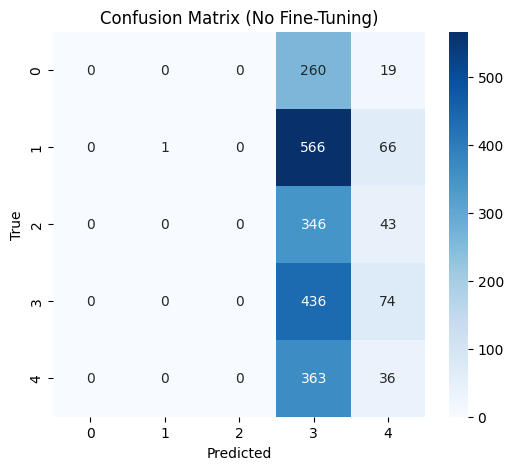

In [12]:


cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (No Fine-Tuning)")
plt.show()
